## Elastic constants from charge density distribution in FCC high entropy alloys using CNN and DFT 

This code has been provided to generate the results of the paper "Elastic constants from charge density distribution in FCC high entropy alloys using CNN and DFT". The code can be used for training and evaluation of the results presented in the paper.

### Importing required libraries

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse 
import datetime
import matplotlib.pyplot as plt

month = datetime.datetime.now().strftime("%b")
day = datetime.datetime.today().day
mydate = month+str(day)


# Set random seed number for reproduction
seed = 42

In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Choose which targets to predict: Can choose from single to several at a time
targets_to_predict = ['c11', 'c12', 'c44', 'G', 'B', 'E_VRH', 'nu', 'Cohesive_energy']
# targets_to_predict = ['c11']

if len(targets_to_predict) == 8:
    targs = 'allproperties'
elif len(targets_to_predict) == 1:
    targs = targets_to_predict[0]
else:
    targs = str(len(targets_to_predict))+'properties'

In [10]:
# Choose your desired amount of binary and/or ternary training ratio (MUST BE WHOLE NUMBER BETWEEN 0 AND 100)
bin_train_ratio = 25

# NOTE: If ternary is not 0, code will train on 100% binary + ternary training ratio
tern_train_ratio = 0


In [11]:
# Check if ratios < 0
assert bin_train_ratio%1==0 and bin_train_ratio >= 0 and bin_train_ratio <= 100, 'Please change binary trianing ratio to a whole number between 0 and 100'
assert tern_train_ratio%1==0 and tern_train_ratio >= 0 and tern_train_ratio <= 100, 'Please change ternary trianing ratio to a whole number between 0 and 100'

### Selecting the training and test datasets

In this paper, we have two approaches. First, we train only on the binary dataset (entire or portion of the data), and next, we use the entire binaries and a portion of the entire ternaries.


In [12]:
#The code below has been used to train only on binaries dataset. 
if tern_train_ratio == 0:
    def generate_train_test_indices(total_binary_count, total_data_count, train_ratio, seed=seed): ## different seed tested such as 42 , 123 , 72  #27, 45, 99
        if seed is not None:
            random.seed(seed)

        binary_indices = list(range(total_binary_count))
        train_count = int(total_binary_count * train_ratio)
        train_indices = random.sample(binary_indices, train_count)
        all_indices = list(range(total_data_count))
        test_indices = [i for i in all_indices if i not in train_indices]
        return train_indices, test_indices
    
#The code below has been used to train on entire binaries dataset plus terneries
else:
    def generate_train_test_indices(total_binary_count, total_data_count, train_ratio, seed=seed): #different seed tested such as 1234, 42, 32
        if seed is not None:
            random.seed(seed)
        binary_indices = list(range(total_binary_count))
        train_indices = binary_indices[:1110]
        remaining_indices_count = total_data_count - len(train_indices)
        additional_train_count = int((remaining_indices_count - 78) * train_ratio)  
        additional_train_indices = random.sample(range(1110, 1473), additional_train_count)
        train_indices.extend(additional_train_indices)
        all_indices = list(range(total_data_count))
        test_indices = [i for i in all_indices if i not in train_indices]
        return train_indices, test_indices

### Defining the loss function and creating the model.

${Fine}$  ${Tuning}$: There are some parameters here that can be fine-tuned based on the data and the application. These parameters include the number of layers, kernel size, dropout ratio, pool size in MaxPooling, and the number of nodes in the dense layer. We tested different parameters, and this model gave us the best accuracy.

It should also be noted that we gray-scaled the images (reducing the last channel size from 3 (RGB) to 1) and reduced the image size to 40x40. This improves the computational cost and does not significantly impact the accuracy of the models.

In [14]:
def custom_loss(y_true, y_pred):
    # mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    mse = tf.keras.losses.MSE(y_true, y_pred)
    sum_squared_true = tf.reduce_sum(tf.square(y_true))
    epsilon = 1e-7
    sum_squared_true = sum_squared_true + epsilon
    loss = mse / sum_squared_true
    return loss

def build_model(kernel_size, dropout, targets_to_predict):
    conv1 = layers.Conv3D(16, kernel_size, activation='relu', data_format="channels_last", padding="same")
    ap1 = layers.MaxPooling3D(pool_size=(2, 2, 2))
    conv2 = layers.Conv3D(32, kernel_size, activation='relu', data_format="channels_last", padding="same")
    ap2 = layers.MaxPooling3D(pool_size=(2, 2, 2))
    conv3 = layers.Conv3D(64, kernel_size, activation='relu', data_format="channels_last", padding="same")
    ap3 = layers.MaxPooling3D(pool_size=(2, 2, 2))
    flat = layers.Flatten()
    drop1 = layers.Dropout(rate=dropout)
    dense1 = layers.Dense(2048, activation='relu')
    drop2 = layers.Dropout(rate=dropout)
    dense2 = layers.Dense(1024, activation='relu')
    dense3 = layers.Dense(len(targets_to_predict), name='parameters')  
    input_layer = keras.Input(shape=(56, 40, 40, 1))
    x = conv1(input_layer)
    x = ap1(x)
    x = conv2(x)
    x = ap2(x)
    x = conv3(x)  
    x = ap3(x)
    x = flat(x)
    x = dense1(x)
    x = drop1(x)
    x = dense2(x)
    x = drop2(x)
    outputs = dense3(x)
    model = keras.Model(inputs=input_layer, outputs=outputs)
    return model

### Importing the required data: images in the form of numpy arrays and the corresponding elastic properties.

The CSV file and the NumPy array file are needed as inputs for the code. The NumPy array includes all the 3D configurations, while the CSV file contains the corresponding elastic properties for each configuration.

In [15]:
### These are input data including the images and corresponding properties
images = np.load("merged_array.npy")   
properties = pd.read_csv("merged_csv.csv")

### Selecting the properties and generating the train, test, and validation datasets.


The code generates indices for the training, validation, and test datasets. Depending on the study type, choose one of the `generate_train_test_indices` functions and comment out the other. This choice depends on whether we are training with binary datasets only or considering both entire binary datasets and portions of ternary datasets. Note that the `train_ratio` variable in the code below indicates the percentage of data allocated for training, based on our specific application. For instance, the `train_ratio` can select either 25% of binary data or the entirety of binary data along with 25% of ternary data.

Also, please note that we can select two other important properties in the code below:

1. We can choose which elastic properties to use for training the model. If we select all properties, this code will work as is. However, if we use fewer properties, we will need to adjust the model accordingly.
2. We can choose whether to normalize the data simply by selecting scaler.fit_transform or removing it.

In [16]:
if tern_train_ratio == 0:
    train_indices, test_indices = generate_train_test_indices(total_binary_count=1110, total_data_count=1550, train_ratio=bin_train_ratio/100)  ## train_ratio might change based on the number of images use for training process
else:
    train_indices, test_indices = generate_train_test_indices(total_binary_count=1110, total_data_count=1550, train_ratio=tern_train_ratio/100)  ## train_ratio might change based on the number of images use for training process

X_train = images[train_indices]
X_test = images[test_indices]
y_train= properties.iloc[train_indices][targets_to_predict]
y_test = properties.iloc[test_indices][targets_to_predict]


# To select only some specific properties we need to adjust the code below. This code consider all 8 elastic properties

scaler = MinMaxScaler()
y_train.loc[:,targets_to_predict] = scaler.fit_transform(y_train[targets_to_predict])
y_train = y_train[targets_to_predict]
y_test.loc[:,targets_to_predict] = scaler.fit_transform(y_test[targets_to_predict])
y_test = y_test[targets_to_predict]
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Split training data into training and validation datasets 
np.random.seed(seed)
val_split = 0.1 # validation = 10% of training, change if desired
val_size = int(X_train.shape[0] * val_split)
val_indices = np.random.choice(X_train.shape[0], val_size, replace=False)
val_data = (X_train[val_indices], y_train.iloc[val_indices])
train_data = (np.delete(X_train, val_indices, axis=0), y_train.drop(index=val_indices))

In [17]:
train_indices = [i for i in train_indices if i not in val_indices]
all_indices = np.arange(0, 1550)
data = []
for idx in all_indices:
    if idx in val_indices:
        set_type = 'validation'
    elif idx in train_indices:
        set_type = 'training'
    elif idx in test_indices:
        set_type = 'test'
    else:
        set_type = 'none'
    data.append((idx, set_type))
df = pd.DataFrame(data, columns=['index', 'set_type'])

### Compiling and training the model

Here we also have some hyperparameters that can be changed based on the data and application. These hyperparameters include patience in the EarlyStopping function, as well as factor, patience, and minimum learning rate in the ReduceLROnPlateau function.

In [18]:
model = build_model((3, 3, 11), 0.3, targets_to_predict)
    
if tern_train_ratio == 0:
    checkpoint_callback = ModelCheckpoint(f"weights/{mydate}_{targs}_{str(bin_train_ratio)}B.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
else:
    checkpoint_callback = ModelCheckpoint(f"weights/{mydate}_{targs}_100B_{str(tern_train_ratio)}T.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=30, min_lr=1e-7)
model.compile(optimizer='adam', loss=custom_loss)

2024-07-17 15:53:56.222684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14471 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [20]:
# history = model.fit(train_data[0], train_data[1], 
#                     batch_size=128, 
#                     epochs=5000, 
#                     validation_data=val_data,
#                     callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback])

history = model.fit(train_data[0], train_data[1], 
                    batch_size=128, 
                    epochs=10, 
                    validation_data=val_data,
                    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback])
print('Done fitting model')

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 2.2452e-04 - val_loss: 9.9296e-04 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.3507e-04 - val_loss: 9.3335e-04 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.1691e-04 - val_loss: 9.0678e-04 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.0907e-04 - val_loss: 8.9816e-04 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.0837e-04 - val_loss: 9.2622e-04 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 2.0261e-04 - val_loss: 8.9996e-04 - learning_rate: 0.0010
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.0393e-04 - val_loss: 9.0579e-04 - learning_rate: 0.0010
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.9914e-04 - val_loss: 8.5064e-04 - learning_rate: 0.0010
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.9239e-04 - val_loss: 

### Model evaluation

This code can be used to evaluate the results, save them in a csv file, and obtain the $R^{2}$ score for the training, test, and validation datasets.

In [21]:
history_df = pd.DataFrame(history.history)

if tern_train_ratio == 0:
    history_df.to_csv(f'losses/{mydate}_{targs}_{bin_train_ratio}B.csv', index=False)
else:
    history_df.to_csv(f'losses/{mydate}_{targs}_100B_{tern_train_ratio}T.csv', index=False)

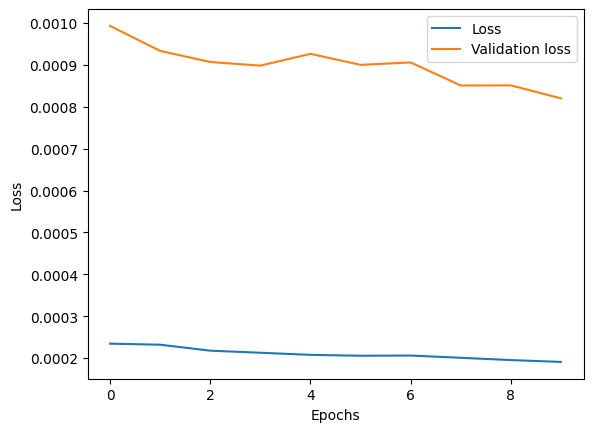

In [23]:
# Plot losses for model
epochs = list(range(0,len(history_df)))
plt.plot(epochs,history_df['loss'],label='Loss')
plt.plot(epochs,history_df['val_loss'],label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Load in trained model from this session for evaluation/new predictions

In [24]:
# model.load_weights("weights/May14_allproperties_25B.h5")
if tern_train_ratio == 0:
    model.load_weights(f'weights/{mydate}_{targs}_{bin_train_ratio}B.weights.h5')
else:
    model.load_weights(f'weights/{mydate}_{targs}_100B_{tern_train_ratio}T.weights.h5')

predictions = model.predict(images)
denormalized_predictions = scaler.inverse_transform(predictions)
denormalized_df = pd.DataFrame(denormalized_predictions, columns=targets_to_predict)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [25]:
assert denormalized_df.shape[0] == df.shape[0], "The number of rows in both DataFrames must be the same."
merged_df = pd.concat([df, denormalized_df], axis=1)
if tern_train_ratio == 0:
    merged_df.to_csv(f'results/{mydate}_{targs}_results_{bin_train_ratio}B.csv',index=False)
else:
    merged_df.to_csv(f'results/{mydate}_{targs}_results_100B_{tern_train_ratio}T.csv',index=False)

Plot the quaternary and quinary results on top of all results with their R^2 and RMSE values

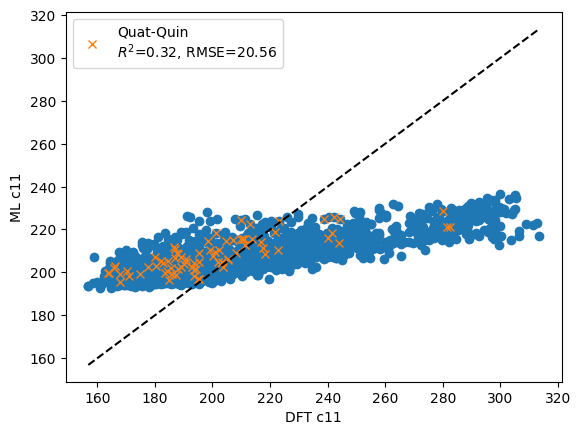

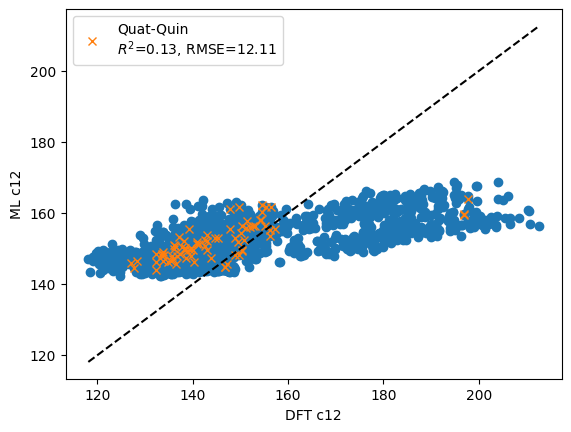

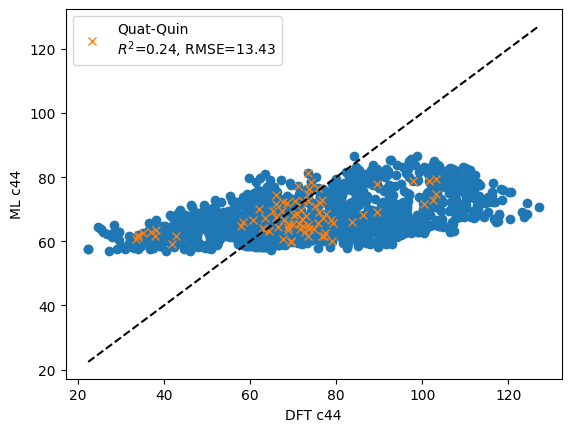

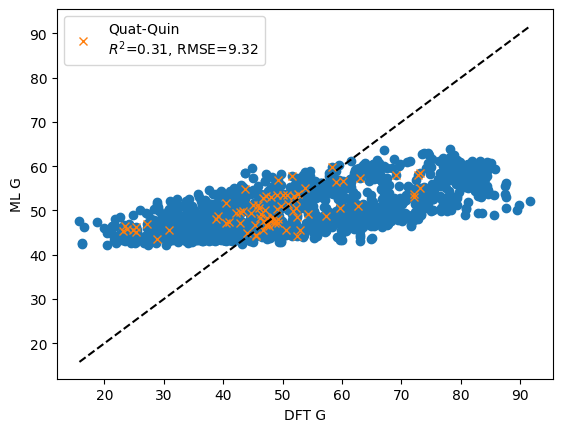

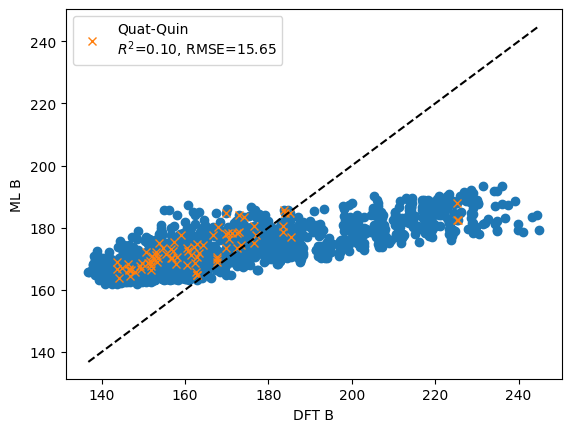

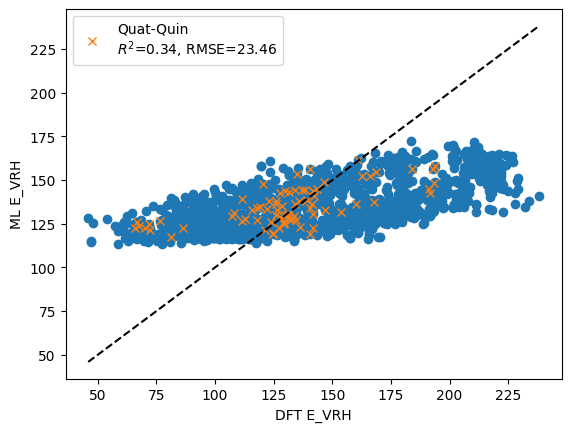

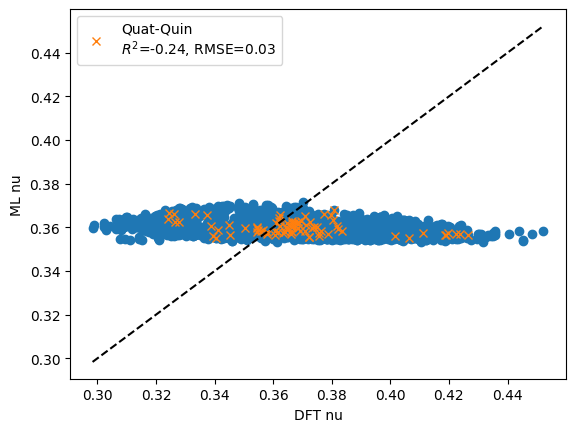

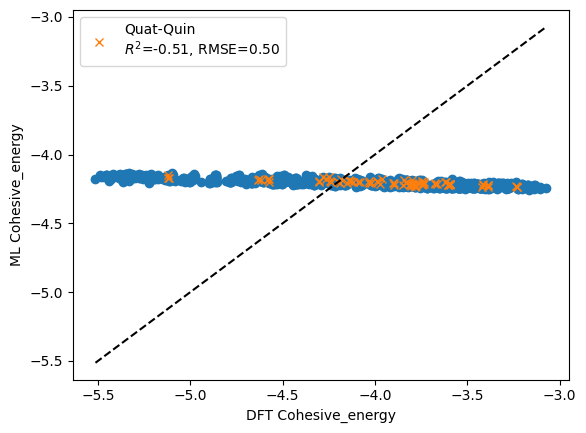

In [26]:
for i in targets_to_predict:
    r2 = r2_score(properties[i].iloc[1472::], denormalized_df[i].iloc[1472::])
    rmse = np.sqrt(mse(properties[i].iloc[1472::], denormalized_df[i].iloc[1472::]))
    # print(i,': $R^2$=',round(r2,2))
    plt.plot(properties[i],denormalized_df[i],'o')
    plt.plot(properties[i].iloc[1472::], denormalized_df[i].iloc[1472::],'x',label='Quat-Quin\n$R^2$=%.2f, RMSE=%.2f'%(round(r2,2),round(rmse,2)))
    plt.plot([properties[i].min(),properties[i].max()],[properties[i].min(),properties[i].max()],'k--')
    plt.xlabel(f'DFT {i}')
    plt.ylabel(f'ML {i}')
    plt.legend()
    plt.show()

## Load previously trained models and obtain R^2 and RMSE for Testing (ternary + quaternary + quinary), Training (binary + ternary), Validation (binary + ternary)

In [27]:
# Choose parameters for previously trained model
load_date = 'May14' # Specify the date you would like to load your model from
# load_date = 'June4'


# Choose which targets to predict: Can choose from single to several at a time
targets_to_predict = ['c11', 'c12', 'c44', 'G', 'B', 'E_VRH', 'nu', 'Cohesive_energy']
# targets_to_predict = ['c11']

if len(targets_to_predict) == 8:
    targs = 'allproperties'
elif len(targets_to_predict) == 1:
    targs = targets_to_predict[0]
else:
    targs = str(len(targets_to_predict))+'properties'
    
# Choose your desired amount of binary and/or ternary training ratio (MUST BE WHOLE NUMBER BETWEEN 0 AND 100)
bin_prev_ratio = 100

# NOTE: If ternary is not 0, code will train on 100% binary + ternary training ratio
tern_prev_ratio = 100


# Check if ratios < 0
assert bin_prev_ratio%1==0 and bin_prev_ratio >= 0 and bin_prev_ratio <= 100, 'Please change binary trianing ratio to a whole number between 0 and 100'
assert tern_prev_ratio%1==0 and tern_prev_ratio >= 0 and tern_prev_ratio <= 100, 'Please change ternary trianing ratio to a whole number between 0 and 100'

In [28]:
if tern_prev_ratio == 0:
    train_indices, test_indices = generate_train_test_indices(total_binary_count=1110, total_data_count=1550, train_ratio=bin_prev_ratio/100)  ## train_ratio might change based on the number of images use for training process
else:
    train_indices, test_indices = generate_train_test_indices(total_binary_count=1110, total_data_count=1550, train_ratio=tern_prev_ratio/100)  ## train_ratio might change based on the number of images use for training process

X_train = images[train_indices]
X_test = images[test_indices]
y_train= properties.iloc[train_indices][targets_to_predict]
y_test = properties.iloc[test_indices][targets_to_predict]


# Use scaled values if model is for all properties and date is May 14
if load_date == 'May14' and targs == 'allproperties':
    scaler = MinMaxScaler()
    y_train.loc[:,targets_to_predict] = scaler.fit_transform(y_train[targets_to_predict])
    y_train = y_train[targets_to_predict]
    y_test.loc[:,targets_to_predict] = scaler.fit_transform(y_test[targets_to_predict])
    y_test = y_test[targets_to_predict]
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
# Otherwise use unscaled data
else:
    y_train = y_train[targets_to_predict]
    y_test = y_test[targets_to_predict]
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    

# Split training data into training and validation datasets 
np.random.seed(seed)
val_split = 0.1 # validation = 10% of training, change if desired
val_size = int(X_train.shape[0] * val_split)
val_indices = np.random.choice(X_train.shape[0], val_size, replace=False)
val_data = (X_train[val_indices], y_train.iloc[val_indices])
train_data = (np.delete(X_train, val_indices, axis=0), y_train.drop(index=val_indices))

In [29]:
model = build_model((3, 3, 11), 0.3, targets_to_predict)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


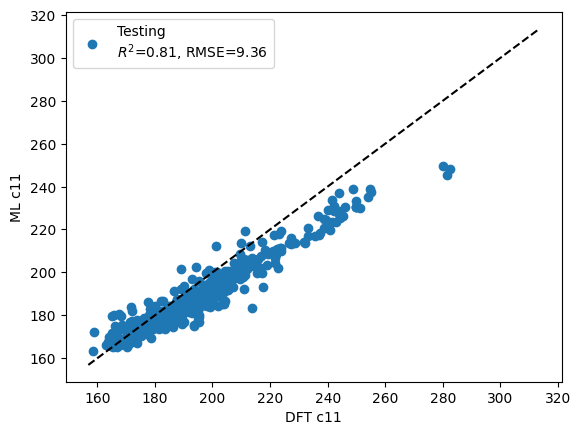

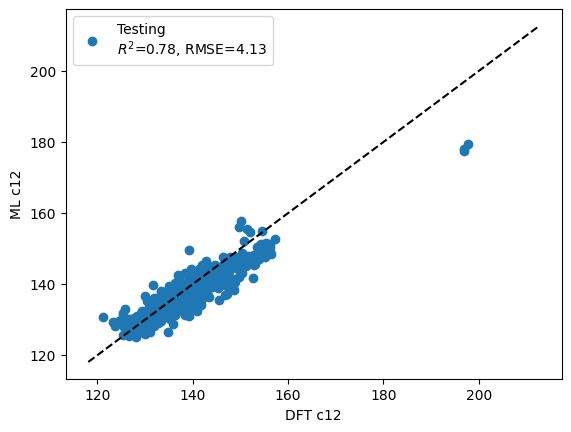

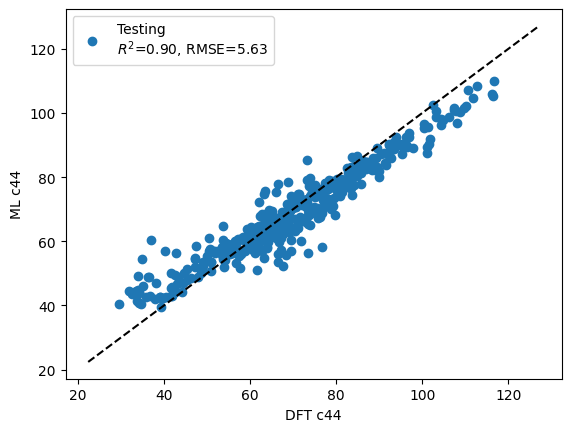

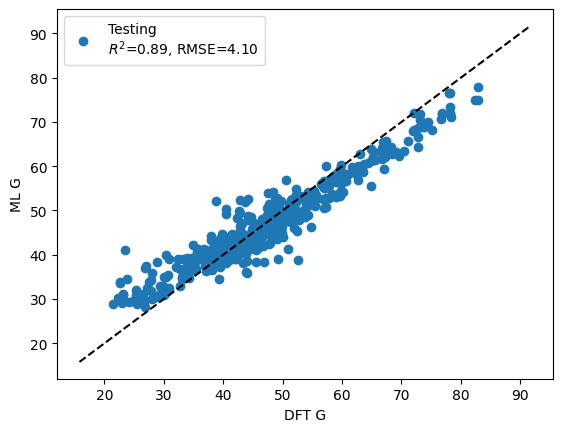

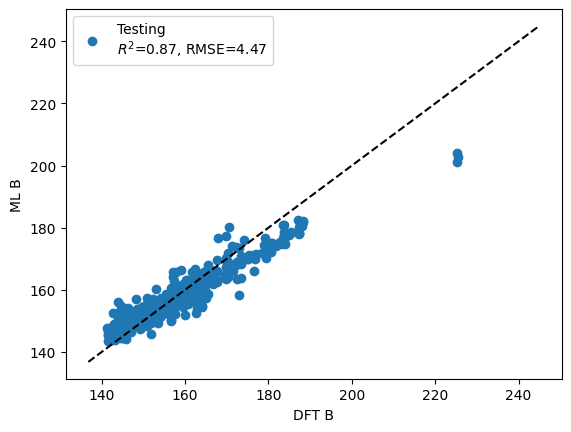

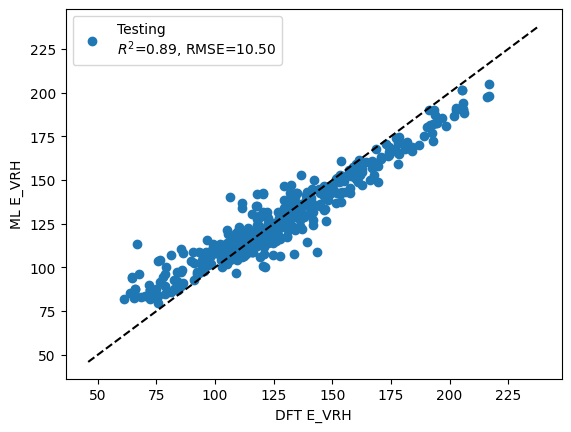

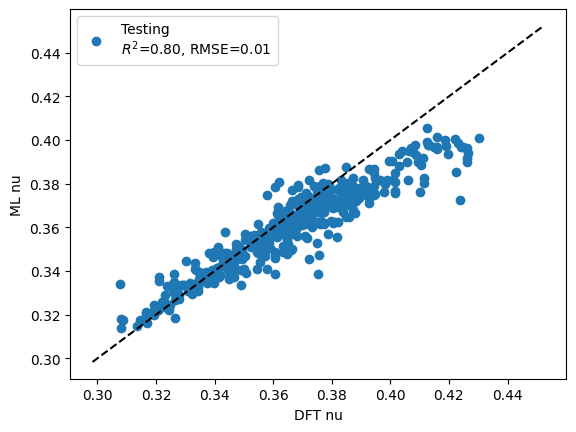

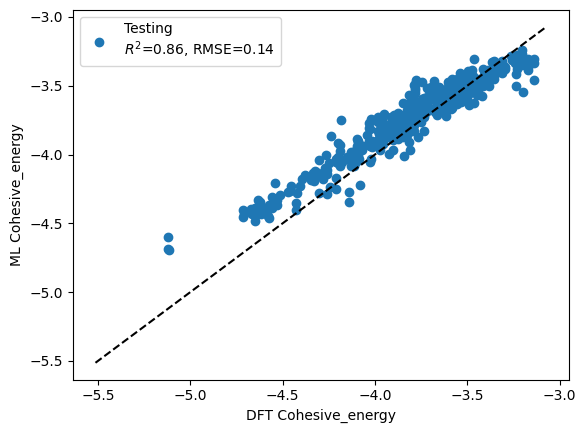

Testing R2-scores for each target parameter: May14 [['c11', 0.812], ['c12', 0.783], ['c44', 0.895], ['G', 0.892], ['B', 0.873], ['E_VRH', 0.89], ['nu', 0.804], ['Cohesive_energy', 0.862]]


In [30]:
# Load pretrained model
if tern_prev_ratio == 0:
    model.load_weights(f'weights/{load_date}_{targs}_{bin_prev_ratio}B.h5')
    # model.load_weights(f'weights/{load_date}_c11_{bin_prev_ratio}B.h5')
else:
    model.load_weights(f'weights/{load_date}_{targs}_100B_{tern_prev_ratio}T.h5')

# Make predictions on testing data 
predictions = model.predict(X_test)

if load_date == 'May14' and targs == 'allproperties':
    denormalized_predictions = scaler.inverse_transform(predictions)
    y_test_denormalized = scaler.inverse_transform(y_test)
    y_test_denormalized = pd.DataFrame(y_test_denormalized, columns=targets_to_predict)
else:
    denormalized_predictions = predictions #.to_numpy()
    y_test_denormalized = pd.DataFrame(y_test, columns=targets_to_predict)

r2_scores = []
for i in range(predictions.shape[1]):
    # r2 = r2_score(y_test.iloc[:, i], predictions[:, i])
    # plt.plot(y_test.iloc[:, i], predictions[:, i],'o')
    r2 = r2_score(y_test_denormalized.iloc[:, i], denormalized_predictions[:, i])
    rmse = np.sqrt(mse(y_test_denormalized.iloc[:, i], denormalized_predictions[:, i]))
    plt.plot(y_test_denormalized.iloc[:, i], denormalized_predictions[:, i],'o',label='Testing\n$R^2$=%.2f, RMSE=%.2f'%(round(r2,2),round(rmse,2)))
    true_line = [properties[targets_to_predict[i]].min(),properties[targets_to_predict[i]].max()]
    plt.plot(true_line,true_line,'k--')
    plt.xlabel(f'DFT {targets_to_predict[i]}')
    plt.ylabel(f'ML {targets_to_predict[i]}')
    plt.legend()
    plt.show()
    # r2_scores.append(r2)
    r2_scores.append([targets_to_predict[i],round(r2,3)])
print(f"Testing R2-scores for each target parameter: {load_date}", r2_scores)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


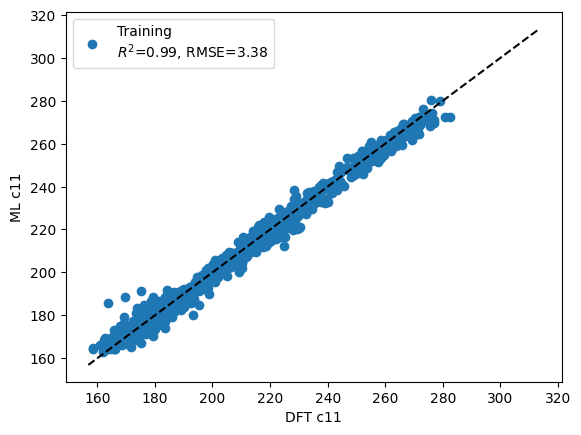

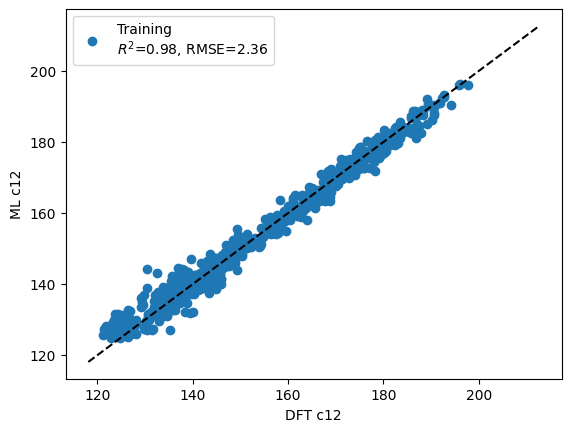

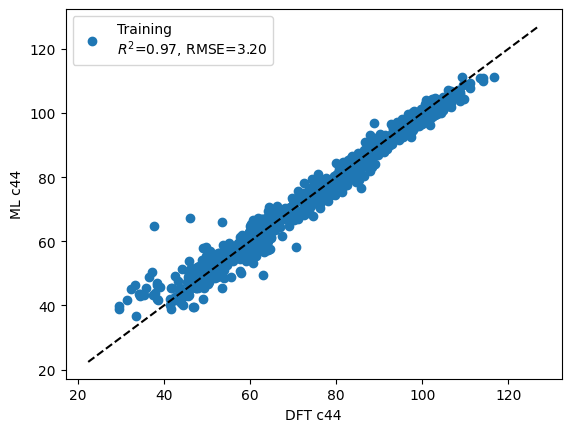

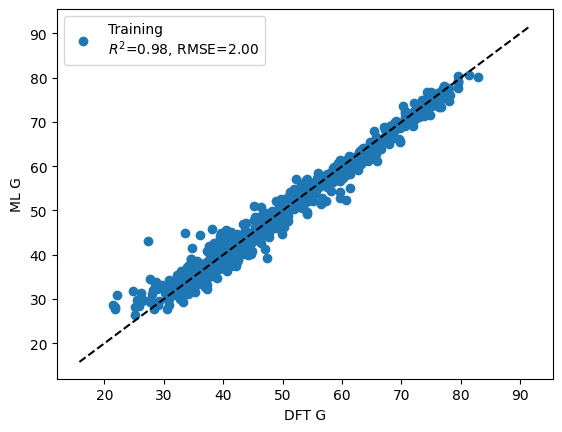

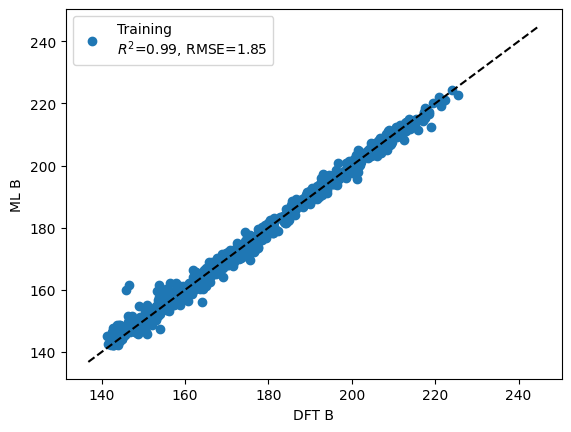

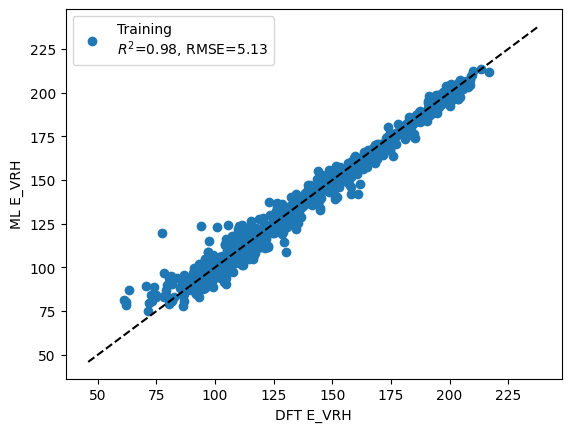

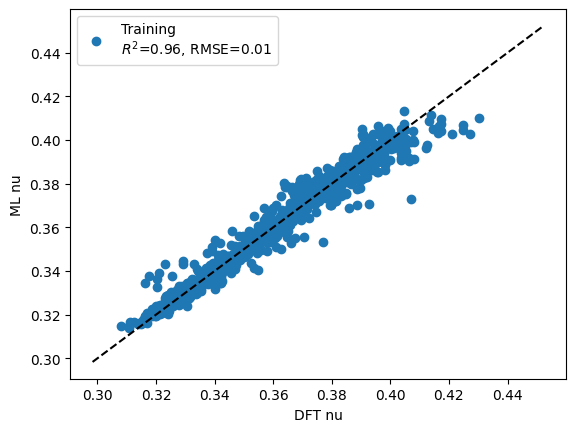

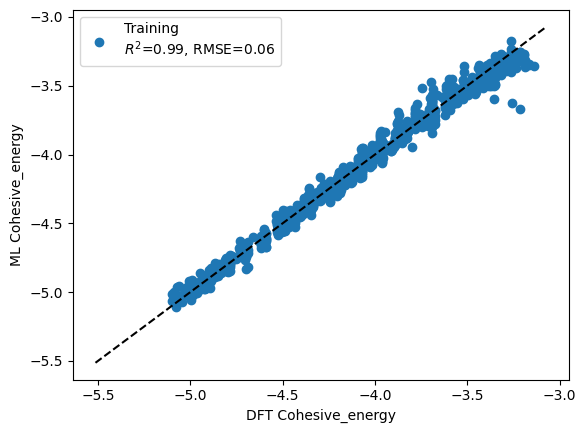

Training R2-scores for each target parameter May14: [['c11', 0.988], ['c12', 0.983], ['c44', 0.971], ['G', 0.978], ['B', 0.992], ['E_VRH', 0.978], ['nu', 0.958], ['Cohesive_energy', 0.988]]


In [31]:
predictions = model.predict(train_data[0])
r2_scores = []


if load_date == 'May14' and targs == 'allproperties':
    denormalized_predictions = scaler.inverse_transform(predictions)
    train_denormalized = scaler.inverse_transform(train_data[1])
    train_denormalized = pd.DataFrame(train_denormalized, columns=targets_to_predict)
else:
    denormalized_predictions = predictions
    train_denormalized = pd.DataFrame(train_data[1], columns=targets_to_predict)


for i in range(predictions.shape[1]):
    # r2 = r2_score(train_data[1].iloc[:, i], predictions[:, i])
    # r2_scores.append(r2)
    r2 = r2_score(train_denormalized.iloc[:, i], denormalized_predictions[:, i])
    rmse = np.sqrt(mse(train_denormalized.iloc[:, i], denormalized_predictions[:, i]))
    plt.plot(train_denormalized.iloc[:, i], denormalized_predictions[:, i],'o',label='Training\n$R^2$=%.2f, RMSE=%.2f'%(round(r2,2),round(rmse,2)))
    true_line = [properties[targets_to_predict[i]].min(),properties[targets_to_predict[i]].max()]
    plt.plot(true_line,true_line,'k--')
    plt.xlabel(f'DFT {targets_to_predict[i]}')
    plt.ylabel(f'ML {targets_to_predict[i]}')
    plt.legend()
    plt.show()
    r2_scores.append([targets_to_predict[i],round(r2,3)])
print(f"Training R2-scores for each target parameter {load_date}:", r2_scores)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


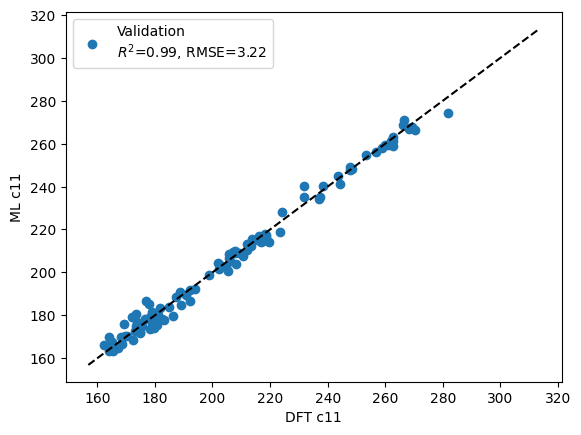

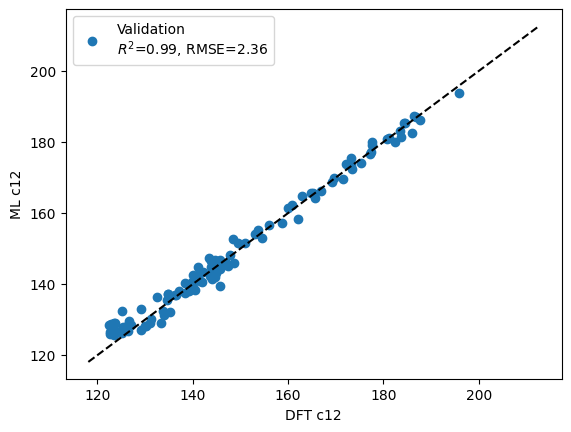

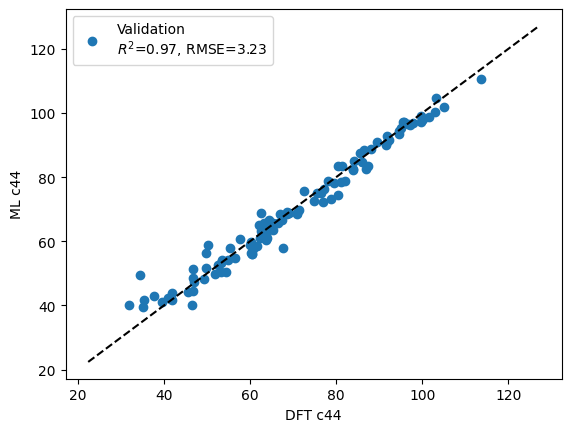

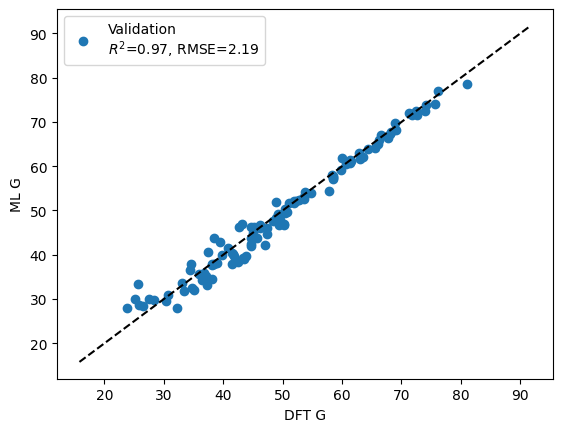

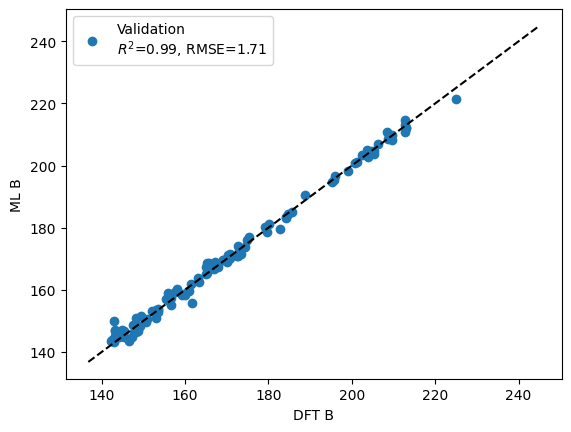

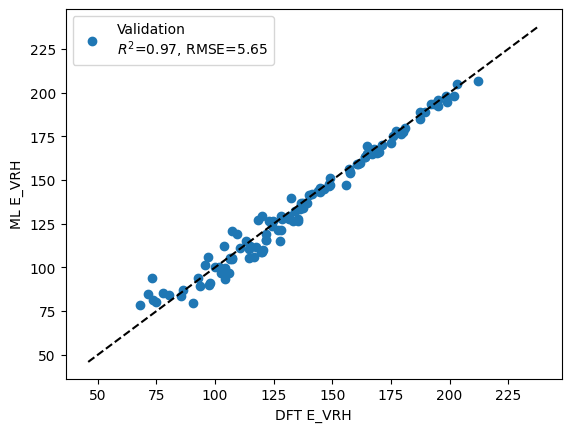

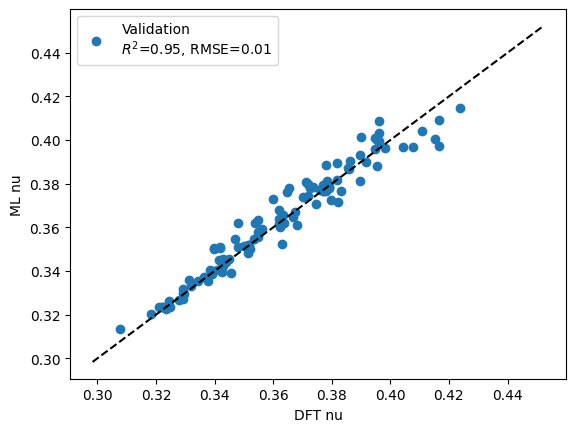

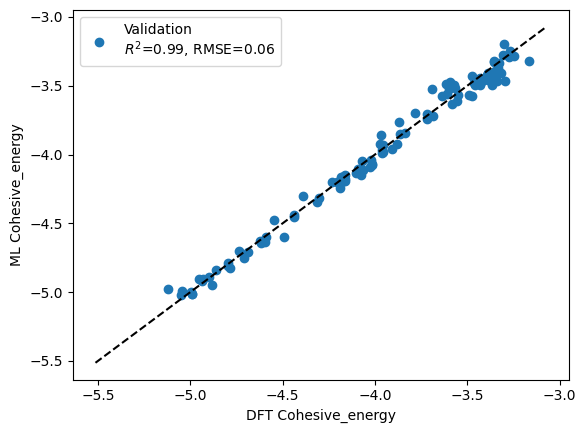

Validation R2-scores for each target parameter from May14: [['c11', 0.99], ['c12', 0.985], ['c44', 0.971], ['G', 0.974], ['B', 0.994], ['E_VRH', 0.973], ['nu', 0.946], ['Cohesive_energy', 0.988]]


In [32]:
predictions = model.predict(val_data[0])
r2_scores = []



if load_date == 'May14' and targs == 'allproperties':
    denormalized_predictions = scaler.inverse_transform(predictions)
    val_data_denormalized = scaler.inverse_transform(val_data[1])
    val_data_denormalized = pd.DataFrame(val_data_denormalized, columns=targets_to_predict)
else:
    denormalized_predictions = predictions
    val_data_denormalized = pd.DataFrame(val_data[1], columns=targets_to_predict)

for i in range(predictions.shape[1]):
    # r2 = r2_score(val_data[1].iloc[:, i], predictions[:, i])
    # r2_scores.append(r2)
    r2 = r2_score(val_data_denormalized.iloc[:, i], denormalized_predictions[:, i])
    rmse = np.sqrt(mse(val_data_denormalized.iloc[:, i], denormalized_predictions[:, i]))
    plt.plot(val_data_denormalized.iloc[:, i], denormalized_predictions[:, i],'o',label='Validation\n$R^2$=%.2f, RMSE=%.2f'%(round(r2,2),round(rmse,2)))
    true_line = [properties[targets_to_predict[i]].min(),properties[targets_to_predict[i]].max()]
    plt.plot(true_line,true_line,'k--')
    plt.xlabel(f'DFT {targets_to_predict[i]}')
    plt.ylabel(f'ML {targets_to_predict[i]}')
    plt.legend()
    plt.show()
    r2_scores.append([targets_to_predict[i],round(r2,3)])
print(f"Validation R2-scores for each target parameter from {load_date}:", r2_scores)